# Исследование зависимости количества поездок от времени суток

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

/home/grin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Считываем данные из csv файла

In [2]:
trip_data = pd.read_csv('../data/trip_data_6_9_15.csv', sep=',')

/home/grin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
trip_data.columns

Index([u'medallion', u'hack_license', u'vendor_id', u'rate_code',
       u'store_and_fwd_flag', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'trip_time_in_secs', u'trip_distance',
       u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude',
       u'dropoff_latitude'],
      dtype='object')

In [4]:
trip_data.head()

medallion                      hack_license  \
0  07A0F87F3E065B7013796526962B61FA  D07EB33A97693D232CEF070432EAA9B3   
1  0DFD8044FC64C1AA272F4B3D7928EEC8  7A45FDCC6A8948A2664AAB5B43C2BBAB   
2  F36564AB9C6EA3B6373EB0E1680A447A  57BAD78FF0BDEC3A1188EFB287CC4ACD   
3  40087D340B9D791ADEE055E7AEC4DE12  77DA8EF55B381C08B0A3C7FBDC71D85A   
4  0FCAD8D2B0D6CAFB4CA81DD5137BE34E  857B6D616015E8C4CEDD1AF17F2C38B2   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       VTS          1                NaN  2013-06-11 15:41:00   
1       VTS          1                NaN  2013-06-15 18:04:00   
2       VTS          2                NaN  2013-06-12 21:55:00   
3       VTS          1                NaN  2013-06-11 18:52:00   
4       VTS          2                NaN  2013-06-14 12:56:00   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-06-11 16:08:00                1               1620           1.36   
1  2013-06-15 18:20:00                1                960           3.77   
2  2013-06-12 21:55:00                2                  0           0.00   
3  2013-06-11 19:29:00                5               2220          19.79   
4  2013-06-14 13:50:00                5               3240          15.79   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  
0        -73.964340        40.776321         -73.973068         40.764240  
1          0.000000         0.000000           0.000000          0.000000  
2          0.000000         0.000000           0.000000          0.000000  
3        -73.784271        40.648651         -73.984619         40.678196  
4        -73.978722        40.763683         -73.781624         40.647324

Рассмотрим столбец "pickup_datetime", в котором содержится время начала поездки. Извлечём из него время hours_from_midnight, которое равно кол-ву часов (с дробной частью), прошедших с начала текущего дня по начала данной поездки.

In [5]:
trip_data['pickup_datetime'] = pd.to_datetime(trip_data['pickup_datetime'])

In [6]:
def convert_datetime_to_seconds(dt):
    time = dt.time()
    return time.hour + time.minute / float(60) + time.second / float(3600)

trip_data['hours_from_midnight'] = trip_data['pickup_datetime'].apply(convert_datetime_to_seconds)

Вычислим номер дня недели, исходя из pickup_datetime.

In [7]:
trip_data['week_day'] = trip_data['pickup_datetime'].apply(lambda t: t.weekday())

In [8]:
sns.set(rc={"figure.figsize": (8, 4)})

In [9]:
weekday_strs = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

In [10]:
grouped_by_weekday = trip_data.groupby('week_day')

Построим гистограммы времени начала поездки. Каждый отдельный график соответствует одному дню недели. Последний - сразу всем.

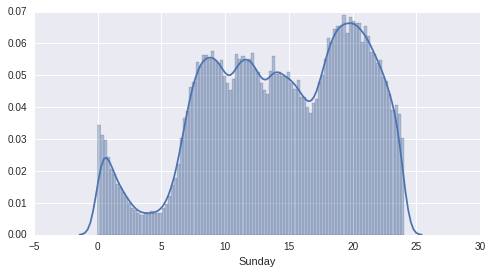

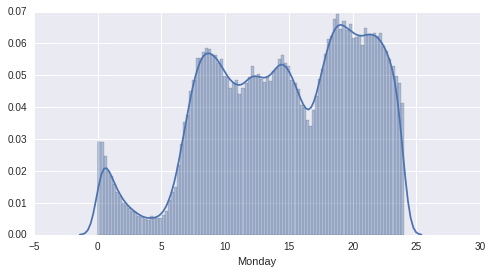

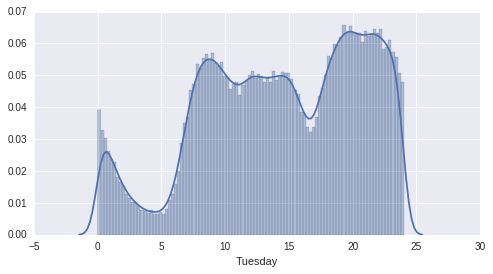

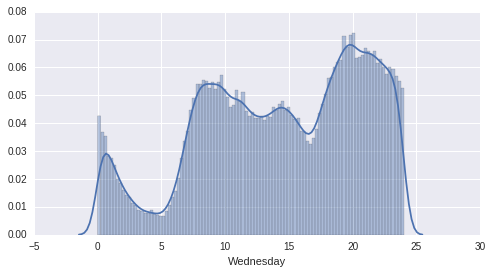

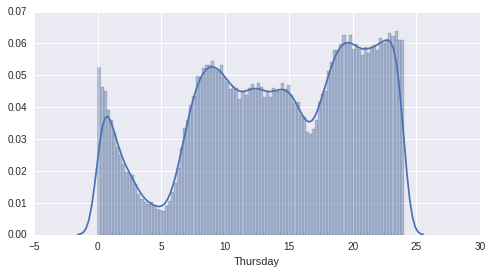

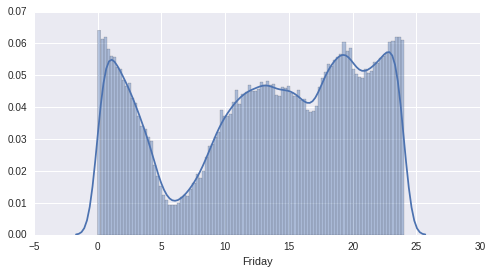

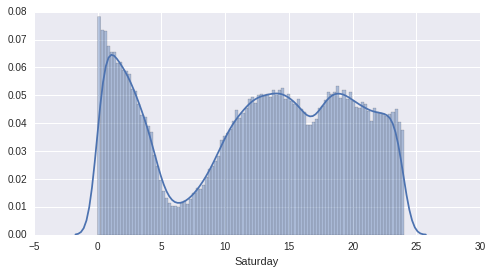

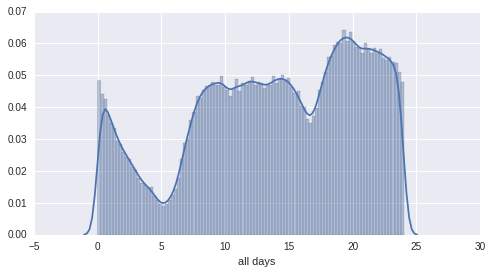

In [12]:
def plot_time_distr():
    for group in grouped_by_weekday.groups:
        plt.figure()
        sns.distplot(grouped_by_weekday.get_group(group)['hours_from_midnight'], bins=100, axlabel=weekday_strs[group])
        
    plt.figure()
    sns.distplot(trip_data['hours_from_midnight'], bins=100, axlabel="all days")

plot_time_distr()

Во все дни есть провал в кол-ве поездок ближе к утру, часов в 5. Также есть минимум примерно в 16.00, наверное перед час-пиком, когда все с работы едут. Также можно отметить, что, начиная с воскресенья, двигаясь к субботе, растет относительная доля ночных поездок за день. Она достигает максимума в ночь с пятницы на субботу. Вероятно в эту ночь все отдыхают после рабочей недели. Хотя, в ночь с четверга на пятницу тоже поездок много. В субботу вечером всем уже влом куда-то ехать, в отличие от остальных дней. В воскресенье вечером все опять куда-то поехали :) Это похоже на то, как в ночь с пятницы на субботу все едут на дачу, а в воскресенье вечером возвращаются. Не ясно только, почему для этого используются такси.

Изобразим на карте 10000 мест начала поездок. Для отображения времени используется цвет. Синий - 00.00, красный - 23.59. Если нажать на точку мышкой, то появится кол-во часов, прошедшее с начала текущего дня.

In [13]:
import folium
from matplotlib import cm
import math
import struct
NEW_YORK_COORDINATES = (40.7127, -74.0059)
data1 = grouped_by_weekday.get_group(1).sample(10000)

map_osm = folium.Map(location=NEW_YORK_COORDINATES)

def rgb_to_hex(color):
    color = map(lambda x: int(math.floor(x*255)), color)
    return '#' + struct.pack('BBB', *color).encode('hex')

for i in range(0, data1.shape[0]):
    lon = data1["pickup_longitude"].values[i]
    lat = data1["pickup_latitude"].values[i]
    color = cm.jet(data1['hours_from_midnight'].values[i] / 24)
    color_str = rgb_to_hex(color[0:3])
    map_osm.circle_marker(location=[lat,lon], popup=str(data1['hours_from_midnight'].values[i]), fill_color=color_str, radius=10, fill_opacity=0.5, line_color=color_str)
    
map_osm

# Исследование зависимости стоимости от длительности и длины поездки

Считываем данные о стоимости поездок из файла (это другая таблица)

In [14]:
trip_fare = pd.read_csv('../data/trip_fare_6_9_15.csv', sep=',')

In [15]:
trip_fare.head()

medallion                      hack_license  \
0  07A0F87F3E065B7013796526962B61FA  D07EB33A97693D232CEF070432EAA9B3   
1  0DFD8044FC64C1AA272F4B3D7928EEC8  7A45FDCC6A8948A2664AAB5B43C2BBAB   
2  F36564AB9C6EA3B6373EB0E1680A447A  57BAD78FF0BDEC3A1188EFB287CC4ACD   
3  40087D340B9D791ADEE055E7AEC4DE12  77DA8EF55B381C08B0A3C7FBDC71D85A   
4  0FCAD8D2B0D6CAFB4CA81DD5137BE34E  857B6D616015E8C4CEDD1AF17F2C38B2   

  vendor_id      pickup_datetime payment_type  fare_amount  surcharge  \
0       VTS  2013-06-11 15:41:00          CSH         13.0          0   
1       VTS  2013-06-15 18:04:00          CSH         14.5          0   
2       VTS  2013-06-12 21:55:00          CRD         52.0          0   
3       VTS  2013-06-11 18:52:00          CSH         55.0          1   
4       VTS  2013-06-14 12:56:00          CSH         52.0          0   

   mta_tax  tip_amount  tolls_amount  total_amount  
0      0.5           0          0.00         13.50  
1      0.5           0          0.00         15.00  
2      0.5           0          0.00         52.50  
3      0.5           0          0.00         56.50  
4      0.5           0          5.33         57.83

Берём из неё информацию о стоимости поездки и подсоединяем к исходному датафрэйму.

In [16]:
trip_data['total_amount'] = trip_fare['total_amount']

Строим гистограмму для полной стоимости поездки

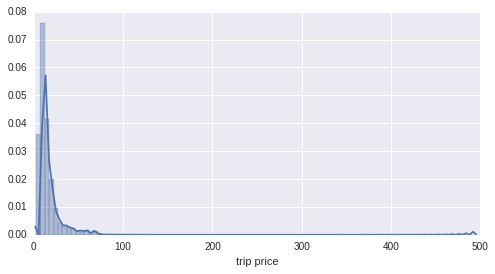

In [17]:
sns.distplot(trip_data['total_amount'], bins=100, axlabel="trip price")

Чтобы лучше было видно, возьмём только те поездки, которые обошлись клиентам меньше, чем в 100 долларов. Интересно, что есть небольшой пик в гистограмме рядом с отметкой в 500 долларов. Кто-то хорошо потратился...

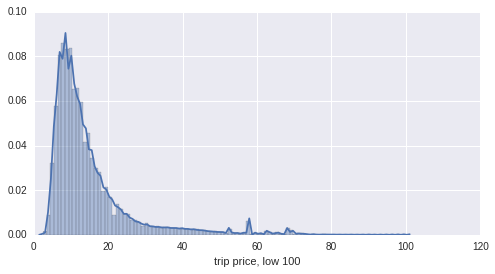

In [18]:
sns.distplot(trip_data[trip_data['total_amount'] < 100]['total_amount'], bins=100, axlabel="trip price, low 100")

Строим гистограмму для дистанции, которую приодолел автомобиль

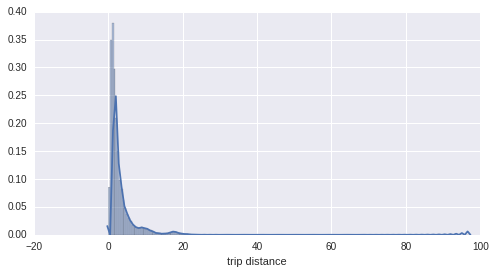

In [19]:
sns.distplot(trip_data['trip_distance'], bins=200, axlabel="trip distance")

Посмотрим на совместное распределение дистанции и полной стоимости

/home/grin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


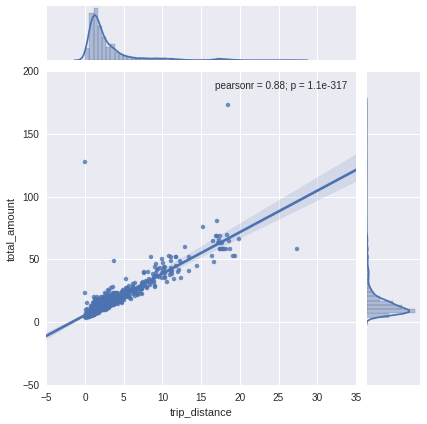

In [20]:
sns.jointplot(x="trip_distance", y="total_amount", data=trip_data.sample(1000), kind='reg')

Почти что линейная зависимость, что ожидаемо

Посмотрим на зависимость расстояния от времени поездки

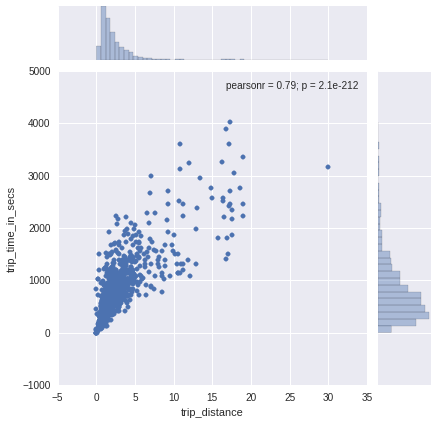

In [21]:
sns.jointplot(x="trip_distance", y="trip_time_in_secs", data=trip_data.sample(1000))

Здесь уже не видно линейной зависимости.